In [ ]:
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
import sys
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
def initial_learning_rate(epoch):
    if (epoch >= 0) and (epoch < 500):
        return 0.01
    if (epoch >= 500) and (epoch < 1000):
        return 0.001
    else:
        return 0.0001

In [ ]:
class PDENet:
    # Init
    def __init__(self, xb, yb, tb, ub, xi, yi, ti, ui, x, y, t, layers):
        
        self.dim = 3
        
        self.xb = xb
        self.yb = yb
        self.tb = tb
        self.ub = ub
        self.xi = xi
        self.yi = yi
        self.ti = ti
        self.ui = ui
        self.x = x
        self.y = y
        self.t = t
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.init_NN(layers)
        
        # Initialize parameters
        # self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        # self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.xytb_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyti_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ui_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyt_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])

        self.ub_pred, _ , _ , _ = self.net_u(self.xytb_tf)
        self.ui_pred, _ , _ , _ = self.net_u(self.xyti_tf)
        _ , self.f_u_pred = self.net_f_u(self.xyt_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.ub_tf - self.ub_pred)) + \
                    tf.reduce_mean(tf.square(self.ui_tf - self.ui_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                options = {'maxiter': 5700,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1 * np.finfo(float).eps})    
        self.lossHistogram = []  
        # self.adaptive_rate = tf.placeholder(tf.float32)
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(
    learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-06, use_locking=False,
    name='Adam'
)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                  
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def init_NN(self, layers):
        dim = self.dim
        weights = []
        biases = []
        num_layers = len(layers)
        W = self.xavier_init(size=[layers[0], dim])
        b = tf.Variable(tf.zeros([layers[0],1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b)
        for l in range(1,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l]])
            b = tf.Variable(tf.zeros([layers[l],1], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)  
        W = self.xavier_init(size=[1, layers[-1]])
        b = tf.Variable(tf.zeros([1,1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b) 
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def net_nn(self, X, weights, biases):
        num_layers = len(self.layers)
        S = X
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            S = tf.tanh(tf.add(tf.matmul(W, S), b))
        W = weights[-1]
        b = biases[-1]
        S = tf.add(tf.matmul(W, S), b)
        return S

    def net_u(self, xyt):
        u = self.net_nn(xyt, self.weights, self.biases)
        u = u[:,0]
        grad = tf.gradients(u, xyt)[0]
        u_x = grad[:,0]
        u_y = grad[:,1]
        u_t = grad[:,2]
        return u, u_x, u_y, u_t
        
    def net_f_u(self, xyt):
        u, u_x, u_y, u_t = self.net_u(xyt)

        u_xx = tf.gradients(u_x, xyt)[0][:,0]
        u_yy = tf.gradients(u_y, xyt)[0][:,1]
        et=tf.math.exp(-xyt[:,2])
        sinx1=tf.math.sin(xyt[:,0])
        sinx2=tf.math.sin(xyt[:,1])
        cosx1=tf.math.cos(xyt[:,0])
        cosx2=tf.math.cos(xyt[:,1])
        x1=xyt[:,0]
        x2=xyt[:,1]
        f_u = u_t - (u_xx + u_yy) - (et*sinx1*sinx2*(x1*x2-x1-x2+1)-2*et*(sinx1*cosx2*(x1-1)+sinx2*cosx1*(x2-1)))
        #f_u = u_t - (u_xx + u_yy) -(1+2.0*np.pi*np.pi)*et*tf.math.sin(np.pi*xyt[:,0])*tf.math.sin(np.pi*xyt[:,1])
        return u, f_u
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        self.lossHistogram.append(loss)
      
    def train(self, nIter): 

        tf_dict = {self.xytb_tf: np.concatenate([self.xb, self.yb, self.tb], 1), self.ub_tf: self.ub,
                   self.xyti_tf: np.concatenate([self.xi, self.yi, self.ti], 1), self.ui_tf: self.ui,
                   self.xyt_tf: np.concatenate([self.x, self.y, self.t], 1)}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            # if it % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            self.lossHistogram.append(loss_value)
            start_time = time.time()

        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
    
    def predict(self, x, y, t):
        
        tf_dict = {self.xytb_tf: np.concatenate([x, y, t], 1)}
        
        u = self.sess.run(self.ub_pred, tf_dict)

        # tf_dict = {self.x_tf: x, self.y_tf: y}
        
        # f_u = self.sess.run(self.f_u_pred, tf_dict)
        
        return u

In [ ]:
class sampling_from_rectangle:
    def __init__(self, x_range, y_range, t_range):
        self.x_range = x_range
        self.y_range = y_range
        self.t_range = t_range

    def initial_samples(self, batchsize):
        # batchsize = int(batchsize/10)
        init_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
        init_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)
        init_draw_t = np.random.uniform(self.t_range[0], self.t_range[0], batchsize)

        return init_draw_x, init_draw_y, init_draw_t

    def interior_samples(self, batchsize):
        int_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
        int_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)
        int_draw_t = np.random.uniform(self.t_range[0], self.t_range[1], batchsize)

        return int_draw_x, int_draw_y, int_draw_t

    def boundary_samples(self, batchsize):
        # batchsize = int(batchsize/3)
        a = self.x_range[1]-self.x_range[0]
        b = self.y_range[1]-self.y_range[0]

        draw_perimeter = np.random.uniform(0, 2*(a + b), batchsize)

        draw = []

        for i in draw_perimeter:
            if i < a:
                draw.append([i+ self.x_range[0], self.y_range[0]])
            elif a <= i and i < a+b:
                draw.append([self.x_range[1], (i-a) + self.y_range[0]])
            elif a+b <= i and i < 2*a+b:
                draw.append([self.x_range[1] - (i-(a+b)), self.y_range[1]])
            elif 2*a+b <= i and i<= 2*a+2*b:
                draw.append([self.x_range[0], self.y_range[1] - (i-(2*a+b))])

        bound_draw_t = np.random.uniform(self.t_range[0], self.t_range[1], batchsize)
        return np.array(draw)[:, 0], np.array(draw)[:, 1], bound_draw_t

In [ ]:
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    u = []
    for row in data:
        if (row[0] == 0. or row[1] == 0. or row[0] == 1. or row[1] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(0.0)
        else:
            x.append(row[0])
            y.append(row[1])
            u.append(round(np.sin(row[0])*np.sin(row[1])*(row[0]*row[1]-row[0]-row[1]+1), 6))
    return np.array(x), np.array(y), np.array(u), np.array(xb), np.array(yb), np.array(ub)

def sample(T, delta_t, data):
    xi,yi,ui,xb,yb,ub = splitData(data)
    x_arr = np.array([])
    y_arr = np.array([])
    NT = np.int(T/delta_t)
    t = []
    for i in range(NT):
        t.append([round((i+1)*delta_t,6) for e in range(xi.size)])
        x_arr = np.concatenate((x_arr, xi))
        y_arr = np.concatenate((y_arr, yi))
    t = flatArr(t)
    tb = []
    xb_arr = np.array([])
    yb_arr = np.array([])
    for i in range(NT+1):
        tb.append([round(i*delta_t,6) for e in range(xb.size)])
        xb_arr = np.concatenate((xb_arr, xb))
        yb_arr = np.concatenate((yb_arr, yb))
    tb = flatArr(tb)
    ti = np.array([0.0 for e in range(xi.size)])
    ub = np.array([0.0 for e in xb_arr])

    return x_arr, y_arr, t, xi, yi, ti, ui, xb_arr, yb_arr, tb, ub

In [ ]:
dataset = np.genfromtxt('/content/triangle_data_30_30.txt', delimiter=',')
x, y, t, xi, yi, ti, ui, xb, yb, tb, ub = sample(1.0, 0.02, dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
t = t.reshape((t.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
tb = tb.reshape((tb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
xi = xi.reshape((xi.size, 1, 1))
yi = yi.reshape((yi.size, 1, 1))
ti = ti.reshape((ti.size, 1, 1))
ui = ui.reshape((ui.size, 1))
layers = [25,25]

In [ ]:
model = PDENet(xb, yb, tb, ub, xi, yi, ti, ui, x, y, t, layers)
# model = PDENet(xb, yb, tb, ub, x, y, t, layers)
start_time = time.time()                
model.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i + 1 for i in range(epochs)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_epochs,losses, color = 'blue')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')
plt.show()
a_file = open("Loss_Adam.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()


In [ ]:
sampler = sampling_from_rectangle([0.0, 1.0], [0.0, 1.0], [0.0, 1.0])
N = 500;
filename = 'data_'

with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y, bou_draw_t = sampler.boundary_samples(N)
    int_draw_x, int_draw_y, int_draw_t = sampler.interior_samples(N)
    init_draw_x, init_draw_y, init_draw_t = sampler.initial_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], int_draw_t[i],
                             bou_draw_x[i], bou_draw_y[i], bou_draw_t[i], 0.0, 
                             init_draw_x[i], init_draw_y[i], init_draw_t[i], np.sin(init_draw_x[i])*np.sin(init_draw_y[i])*(init_draw_x[i]*init_draw_y[i]-init_draw_x[i]-init_draw_y[i]+1)])

dataset = np.genfromtxt('data_500.csv', delimiter=',')
print(dataset)

[[0.48186871 0.274908   0.9440623  ... 0.87242061 0.         0.01756532]
 [0.51813325 0.96419874 0.33136441 ... 0.90479693 0.         0.01217572]
 [0.99853732 0.26433085 0.25776576 ... 0.40339936 0.         0.03773399]
 ...
 [0.86823341 0.85182138 0.26112521 ... 0.5847899  0.         0.05184855]
 [0.45482837 0.14117142 0.63241711 ... 0.49051652 0.         0.02660924]
 [0.55833982 0.22137132 0.83000768 ... 0.67255368 0.         0.02064877]]


In [ ]:
dataset = np.genfromtxt('data_500.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
t = dataset[:,2]
t = t.reshape((t.size, 1, 1))
xb = dataset[:,3]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,4]
yb = yb.reshape((yb.size, 1, 1))
tb = dataset[:,5]
tb = tb.reshape((tb.size, 1, 1))
ub = dataset[:,6]
ub = ub.reshape((ub.size, 1))
xi = dataset[:,7]
xi = xi.reshape((xi.size, 1, 1))
yi = dataset[:,8]
yi = yi.reshape((yi.size, 1, 1))
ti = dataset[:,9]
ti = ti.reshape((ti.size, 1, 1))
ui = dataset[:,10]
ui = ui.reshape((ui.size, 1))

In [ ]:
def exact_solution(x, y, t):
    et=tf.math.exp(-t)
    sinx1=tf.math.sin(x)
    sinx2=tf.math.sin(y)
    cosx1=tf.math.cos(x)
    cosx2=tf.math.cos(y)
    x1=x
    x2=y
    u = et*sinx1*sinx2*(x1*x2-x1-x2+1)
    return u

In [ ]:
u_e = exact_solution(x, y, t)
u_e = tf.reshape(u_e, [x.size, 1])
u_pred = model.predict(x, y, t)
ub_pred = model.predict(xb, yb, tb)
ui_pred = model.predict(xi, yi, ti)
LossL2 = tf.reduce_mean(tf.square(u_pred - u_e)) + tf.reduce_mean(tf.square(ub_pred - ub)) + tf.reduce_mean(tf.square(ui_pred - ui))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))
LossL2= tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

In [108]:
data = np.genfromtxt('/content/Loss_Adam (1).txt', delimiter='')
RMSProp = []
for row in data:
    RMSProp.append(row)
print(RMSProp)

[0.41294342279434204, 2.776986598968506, 0.16936132311820984, 0.09892380237579346, 0.07428590953350067, 0.06012748181819916, 0.05156555771827698, 0.05088326334953308, 0.04846235364675522, 0.045071154832839966, 0.0361739918589592, 0.06149870529770851, 0.02975408546626568, 0.025220949202775955, 0.02208702079951763, 0.020790815353393555, 0.019845813512802124, 0.01952124759554863, 0.01891832798719406, 0.01775703765451908, 0.016255240887403488, 0.0146787716075778, 0.01414827723056078, 0.013968168757855892, 0.013613992370665073, 0.013330061919987202, 0.012805809266865253, 0.012516485527157784, 0.012379743158817291, 0.012270575389266014, 0.011981070041656494, 0.011531424708664417, 0.010993735864758492, 0.010384652763605118, 0.009579715318977833, 0.008973502553999424, 0.007540554739534855, 0.007070606108754873, 0.006752220448106527, 0.006620699539780617, 0.006490735802799463, 0.006256601773202419, 0.006103902123868465, 0.005503816530108452, 0.004564662463963032, 0.004069372080266476, 0.0039432

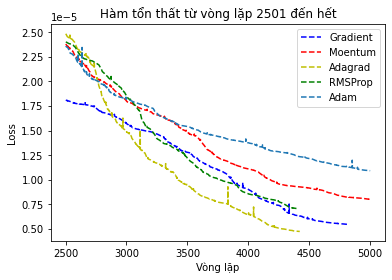

In [ ]:

x= [2501+i+1 for i in range(2499)]

plt.plot([2501+i+1 for i in range(2325)],Gradient[2500:5000],'b--',label='Gradient')
plt.plot([2501+i+1 for i in range(2500)],Momentum[2500:5000],'r--',label='Moentum')
plt.plot([2501+i+1 for i in range(1922)],Adagrad[2500:5000],'y--',label='Adagrad')
plt.plot([2501+i+1 for i in range(1909)],RMSProp[2500:5000],'g--',label='RMSProp')
plt.plot([2501+i+1 for i in range(2500)],Adam[2500:5000],'--',label='Adam')

#plt.plot(x_100, [1,2,3,4,10], 'g-', label='Python')
#plt.plot([0,1,2,3,4], [10,4,3,2,1], 'ro-', label='C#')
#plt.plot([2.5,2.5,2.5,1.5,0.5], [1,3,5,7,10], 'bo-', label='Java')
plt.title('Hàm tổn thất từ vòng lặp 2501 đến hết')
plt.xlabel('Vòng lặp')
plt.ylabel('Loss')
plt.legend()
plt.show()
